In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder,StandardScaler, scale
from sklearn.model_selection import train_test_split  # Libraries for ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics,tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings



In [2]:
df = pd.read_csv('Type_Transport.csv')

# Please only two decimals in the output!!
# This line will give us just two decimals for every pd dataframe displayed
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

df.head()

,Year,Country_Vehicle,value
0,1990,AT_BUS,11.00
1,1990,AT_CAR,77.10
2,1990,AT_TRN,11.90
3,1990,BE_BUS,10.60
4,1990,BE_CAR,83.30


In [3]:
df.shape

(1728, 3)

In [4]:
# # Box plot to identify outliers
# sns.boxplot(x='Luas_Line', y='VALUE', data=df)
# plt.show()


In [5]:
# from scipy import stats

# # Calculate z-scores
# z_scores = stats.zscore(df['VALUE'])

# # Define a threshold for outliers, e.g., 3 standard deviations
# threshold = 1
# outliers = (z_scores > threshold) | (z_scores < -threshold)

# # Print and visualize outliers
# print("Indices of outliers:", df[outliers].index)


In [6]:
# # Remove outliers
# df_no_outliers = df[~outliers]

# # Check the shape of the new dataframe
# print("Shape after removing outliers:", df_no_outliers.shape)


In [7]:
# Move the 'Year' column to the second position
df.insert(2, 'Year', df.pop('Year'))

In [8]:
# Counting the values that each year has:
year_counts = df['Year'].value_counts().sort_index()
year_counts

Year
1990    54
1991    54
1992    54
1993    54
1994    54
1995    54
1996    54
1997    54
1998    54
1999    54
2000    54
2001    54
2002    54
2003    54
2004    54
2005    54
2006    54
2007    54
2008    54
2009    54
2010    54
2011    54
2012    54
2013    54
2014    54
2015    54
2016    54
2017    54
2018    54
2019    54
2020    54
2021    54
Name: count, dtype: int64

In [9]:
# Modify the code to filter based on substrings
df = df[df['Country_Vehicle'].str.contains('IE|HU', case=False, na=False)]


In [10]:
df

,Country_Vehicle,value,Year
27,HU_BUS,24.80,1990
28,HU_CAR,60.50,1990
29,HU_TRN,14.70,1990
30,IE_BUS,11.50,1990
31,IE_CAR,84.90,1990
...,...,...,...
1702,HU_CAR,79.30,2021
1703,HU_TRN,6.40,2021
1704,IE_BUS,13.00,2021
1705,IE_CAR,85.70,2021


In [11]:
# # Creating variables for each year and storing the values to perform Confidence Intervals:

# df_2019 = df[(df['Year'] == 2019)].copy()
# df_2019.reset_index(drop=True, inplace=True)
# df_2020 = df[(df['Year'] == 2020)].copy()
# df_2020.reset_index(drop=True, inplace=True)
# df_2021 = df[(df['Year'] == 2021)].copy()
# df_2021.reset_index(drop=True, inplace=True)
# df_2022 = df[(df['Year'] == 2022)].copy()
# df_2022.reset_index(drop=True, inplace=True)

In [12]:
# Creating a LabelEncoder instance
le = LabelEncoder()

# Encoding the 'Sex' column
df['Country_Vehicle'] = le.fit_transform(df['Country_Vehicle'])
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
df

,Country_Vehicle,value,Year
27,0,24.80,1990
28,1,60.50,1990
29,2,14.70,1990
30,3,11.50,1990
31,4,84.90,1990
...,...,...,...
1702,1,79.30,2021
1703,2,6.40,2021
1704,3,13.00,2021
1705,4,85.70,2021


Encoding target variable *"Luas_Line"*:<br>
*"Red Line"* = 0 <br>
*"Green Line"* = 1<br>
Defining X and y variables:

In [13]:
X = df.iloc[:, [1,2]].values # Dependent variables
y = df.iloc[:, 0].values # Target variable

In [14]:
X

array([[2.480e+01, 1.990e+03],
       [6.050e+01, 1.990e+03],
       [1.470e+01, 1.990e+03],
       [1.150e+01, 1.990e+03],
       [8.490e+01, 1.990e+03],
       [3.600e+00, 1.990e+03],
       [2.340e+01, 1.991e+03],
       [6.320e+01, 1.991e+03],
       [1.330e+01, 1.991e+03],
       [1.190e+01, 1.991e+03],
       [8.430e+01, 1.991e+03],
       [3.700e+00, 1.991e+03],
       [2.290e+01, 1.992e+03],
       [6.390e+01, 1.992e+03],
       [1.320e+01, 1.992e+03],
       [1.230e+01, 1.992e+03],
       [8.420e+01, 1.992e+03],
       [3.500e+00, 1.992e+03],
       [2.320e+01, 1.993e+03],
       [6.450e+01, 1.993e+03],
       [1.240e+01, 1.993e+03],
       [1.260e+01, 1.993e+03],
       [8.380e+01, 1.993e+03],
       [3.600e+00, 1.993e+03],
       [2.350e+01, 1.994e+03],
       [6.430e+01, 1.994e+03],
       [1.220e+01, 1.994e+03],
       [1.360e+01, 1.994e+03],
       [8.300e+01, 1.994e+03],
       [3.400e+00, 1.994e+03],
       [2.360e+01, 1.995e+03],
       [6.440e+01, 1.995e+03],
       [

In [15]:
y

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5])

## Splitting the dataset into the Training set and Test set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Feature Scaling

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# DecisionTreeClassifier
## Training the Decision Tree Classification model on the Training set

In [18]:
classifier = DecisionTreeClassifier(max_depth = 4, random_state = 42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

## Predicting the Test and set results

In [19]:
y_pred = classifier.predict(X_test)

## Making the Confusion Matrix

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         5
           2       0.60      0.75      0.67         4
           3       0.89      0.80      0.84        10
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         4

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.92        39
weighted avg       0.93      0.92      0.93        39

Classifier Accuracy: 92.31


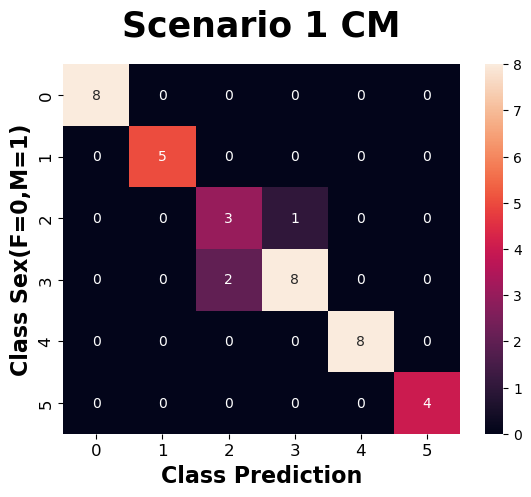

In [20]:
from sklearn.metrics import confusion_matrix # We need to reimport this libary, otherwise breaks

# Calculating confusion matrix

cm = confusion_matrix(y_test, y_pred)

# Call a method heatmap() to plot confusion matrix
sns.heatmap(cm, annot = True,fmt='d')
plt.title('Scenario 1 CM',loc="center", pad=20, fontsize=25, fontweight="bold")
plt.xlabel('Class Prediction',fontsize=16, fontweight='bold')
plt.ylabel('Class Sex(F=0,M=1)',fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# We don't want scientific notation
np.set_printoptions(suppress=True)

# print the classification_report based on y_test and y_predict
print(classification_report(y_test, y_pred))
# Which is the accuracy for the classifier???
print("Classifier Accuracy:",round(metrics.accuracy_score(y_test, y_pred),4)*100)

In [21]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

print('Model accuracy score with 10 decision-trees : {0:0.2f}'. format(accuracy_score(y_test, y_pred)*100))

Model accuracy score with 10 decision-trees : 89.74
